In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns

# Generate dataset

In [2]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

In [3]:
y = -6 * torch.rand(100000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 100000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

In [4]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

# Define NN model and forward SDE

In [6]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_std):
        super().__init__()
        self.act = nn.GELU()#lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.mlp = nn.Sequential(
            nn.Linear(3, int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/16), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/16), int(self.hidden_units/8), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/8), int(self.hidden_units/4), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/4), int(self.hidden_units/2), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units/2), int(self.hidden_units), bias=True),
            nn.GELU(),
            nn.Linear(int(self.hidden_units), 2, bias=True)
        )
    
    def forward(self, x):
        t = x[:, 2]
        x = self.mlp(x)
        x = x / self.marginal_prob_std(t)[:, None]
        return x

In [15]:
device = 'cpu' 
score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)

In [7]:
def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.
    
    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [8]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

# Define sampler

In [334]:
signal_to_noise_ratio = 0.16
num_steps =  500

def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cpu',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns: 
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      

    # The last step does not include any noise
    return x_mean

<hr style="border:2px solid black">

# CDE tailored conditional method

Have a bunch of training points (x,y). Then only forward diffuse the x components, so we get to (x_N, y). Then train NN to approximate the score with inputs (x_t, y, t), and the same loss as the unconditional method.

In [9]:
def CDE_loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    y = torch.reshape(x[:,1], (x.shape[0], 1))
    random_t = torch.rand(x.shape[0], device='cpu') * (1. - eps) + eps  
    std = marginal_prob_std(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None]
    perturbed_x = torch.hstack([perturbed_x,y])
    perturbed_x = perturbed_x[:, [0,2]]
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [252]:
num_steps =  1000
def CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=10000, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, device=device) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    x = torch.hstack([init_x, y_obs])
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps): 

            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 
            
            x = torch.hstack([x,y_obs])
            x = x[:, [0,2]]
            
    # Do not include any noise in the last sampling step.
    return mean_x

In [674]:
actual_samples_pos = np.random.gamma(1,0.3, size = 100000) + np.tanh(1.2)
actual_samples_0 = np.random.gamma(1,0.3, size = 100000) + np.tanh(0)
actual_samples_neg = np.random.gamma(1,0.3, size = 100000) + np.tanh(-1.2)

In [675]:
actual_samples_pos_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 1.2)
actual_samples_0_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 0)
actual_samples_neg_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) - 1.2)

In [676]:
actual_samples_pos_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(1.2)
actual_samples_neg_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(-1.2)

## Example 1

In [28]:
epochs = 300
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_1.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


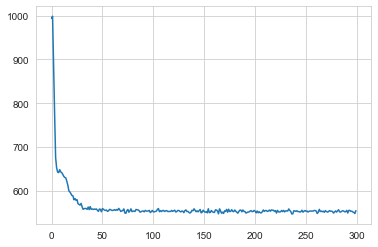

In [29]:
plt.plot(losses)

In [687]:
ckpt = torch.load('models/cde_1.pth', map_location=device)
score_model.load_state_dict(ckpt)
cde_samples_0 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 50000)
cde_samples_pos = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 50000)
cde_samples_neg = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 50000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

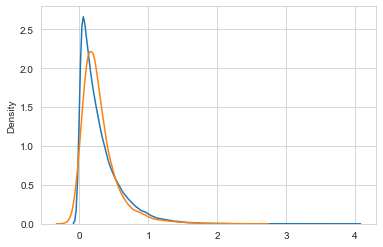

In [690]:
sns.set_style('whitegrid')
sns.kdeplot(actual_samples_0)
sns.kdeplot(cde_samples_0[:,0])

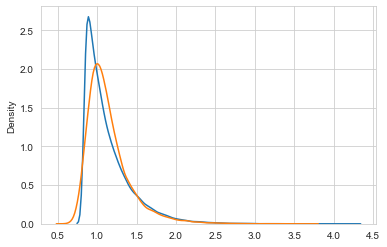

In [691]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cde_samples_pos[:,0])

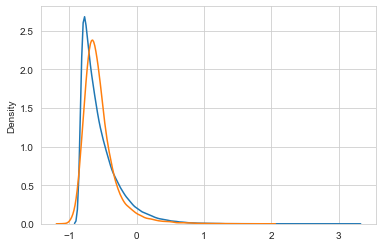

In [692]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cde_samples_neg[:,0])

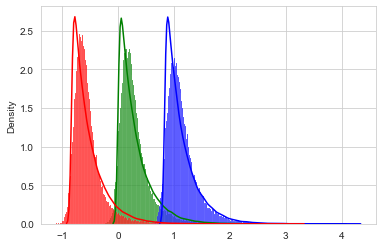

In [693]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cde_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cde_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cde_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [36]:
epochs = 300
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


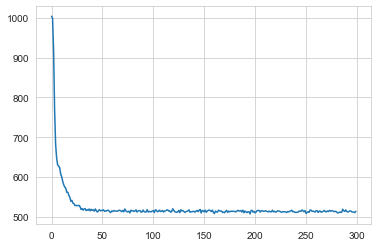

In [37]:
plt.plot(losses)

In [688]:
ckpt = torch.load('models/cde_2.pth', map_location=device)
score_model.load_state_dict(ckpt)
cde_samples_0_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 50000)
cde_samples_pos_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 50000)
cde_samples_neg_2 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 50000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

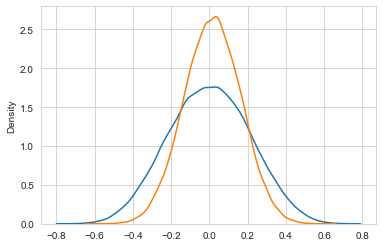

In [694]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cde_samples_0_2[:,0])

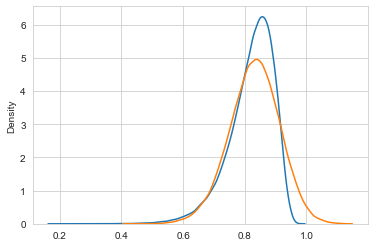

In [695]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cde_samples_pos_2[:,0])

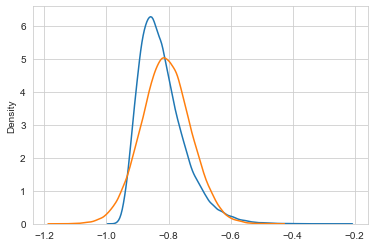

In [696]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cde_samples_neg_2[:,0])

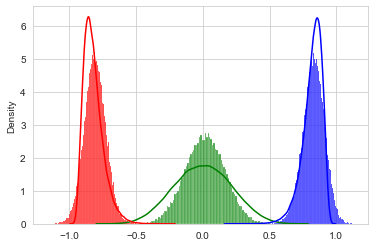

In [697]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cde_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cde_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cde_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [44]:
epochs = 300
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/cde_3.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


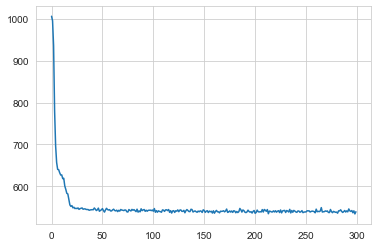

In [45]:
plt.plot(losses)

In [689]:
ckpt = torch.load('models/cde_3.pth', map_location=device)
score_model.load_state_dict(ckpt)
cde_samples_pos_3 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 50000)
cde_samples_neg_3 = CDE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 50000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

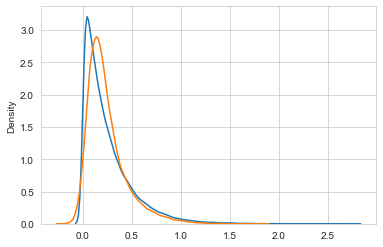

In [698]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cde_samples_pos_3[:,0])

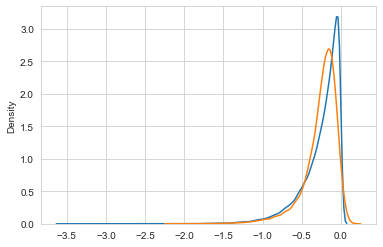

In [699]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cde_samples_neg_3[:,0])

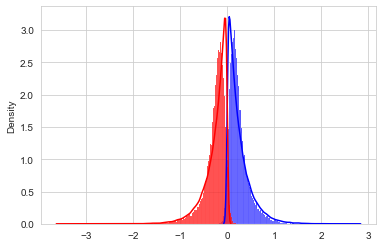

In [700]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cde_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cde_samples_neg_3[:,0], stat = 'density', color = 'red')

<hr style="border:2px solid black">

# CDiffE replacement method

I think, in the case of simulating x|y for this synthetic example, the training stays the same. The difference comes in the sampling. For a given y and timestep t, diffuse y to y_t by the standard forward diffusion. Then at each step of the SDE solver, replace the y value with the diffused y_t.

In [132]:
def get_y_t(y_obs, t):
    std = marginal_prob_std_fn(t)
    z = torch.randn_like(y_obs)
    perturbed_y = y_obs + z * std[:, None]
    return perturbed_y

In [52]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    diffused_y = [y_obs]
    num_steps = timesteps.shape[0]
    dt = 1 / num_steps
    g = diffusion_coeff_fn(timesteps)
    for i in range(num_steps-1):
        g_i = g[i]
        z = np.random.normal(0,1)
        y_i = diffused_y[-1] + g_i * np.sqrt(dt) * z
        diffused_y.append(y_i)
    return diffused_y

In [293]:
num_steps =  1000
def CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=10000, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    diffused_y = [i.repeat(batch_size).reshape(batch_size,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            
            batch_time_step = torch.ones(batch_size) * time_step
            idx = num_steps - idx - 1
            #unstable generation when using this y_t
            #y_obs_t = diffused_y[idx]
            y_obs_t = get_y_t(y_obs, batch_time_step)
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            g = diffusion_coeff(batch_time_step)
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x) 

    return mean_x

## Example 1

In [701]:
ckpt = torch.load('models/ex_1.pth', map_location=device)
score_model.load_state_dict(ckpt)
cdiffe_samples_0 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 50000)

cdiffe_samples_neg = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 50000)

cdiffe_samples_pos = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 50000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

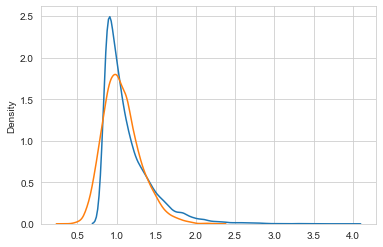

In [289]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cdiffe_samples_pos[:,0])

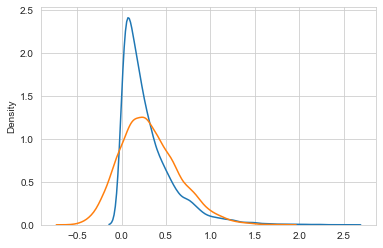

In [290]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(cdiffe_samples_0[:,0])

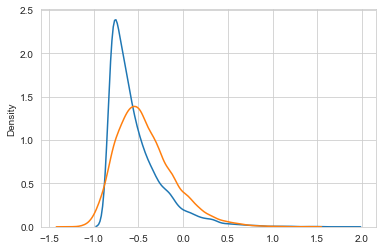

In [291]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cdiffe_samples_neg[:,0])

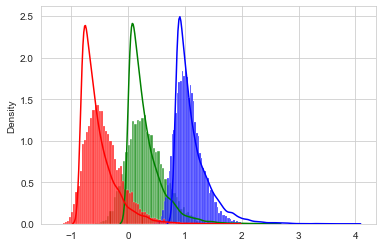

In [292]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [295]:
ckpt = torch.load('models/ex_2.pth', map_location=device)
score_model.load_state_dict(ckpt)
cdiffe_samples_0_2 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32))

cdiffe_samples_neg_2 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

cdiffe_samples_pos_2 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

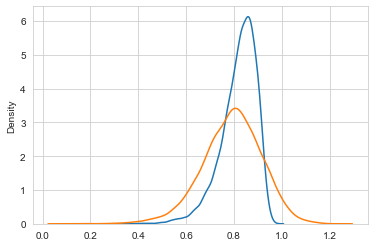

In [296]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cdiffe_samples_pos_2[:,0])

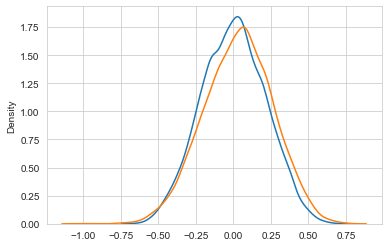

In [297]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cdiffe_samples_0_2[:,0])

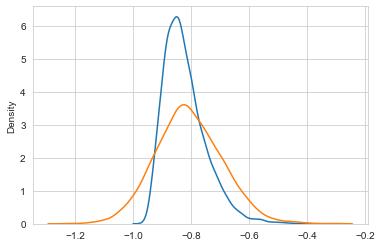

In [298]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cdiffe_samples_neg_2[:,0])

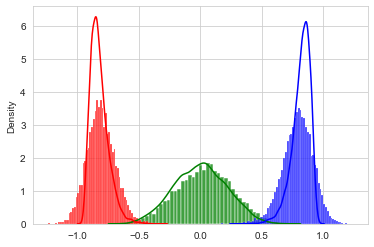

In [299]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cdiffe_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cdiffe_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cdiffe_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [301]:
ckpt = torch.load('models/ex_3.pth', map_location=device)
score_model.load_state_dict(ckpt)
cdiffe_samples_neg_3 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32))

cdiffe_samples_pos_3 = CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32))

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

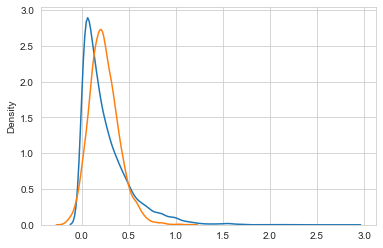

In [302]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cdiffe_samples_pos_3[:,0])

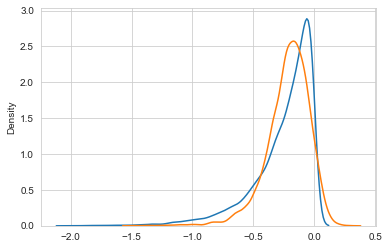

In [303]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cdiffe_samples_neg_3[:,0])

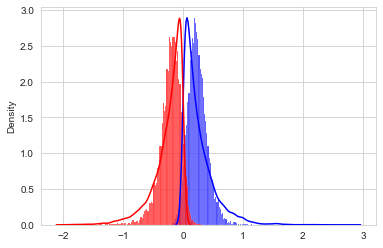

In [304]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cdiffe_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cdiffe_samples_neg_3[:,0], stat = 'density', color = 'red')

<hr style="border:2px solid black">

# SMCDiff method

Similar to the replacement method, but need to add SMC step that looks forward one time step to the diffused condition y_{t-1} to reweight the K samples by the probability p(y_{t-1} | x_t, y_t)

In [75]:
def SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, 
                                   num_steps=1000, eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    y_obs: A tensor of the conditional y information
    k: The number of particles used in particle filtering
    batch_size: The number of samples to generate by calling this function once.
    num_steps: The number of sampling steps. Equivalent to the number of discretized time steps.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(k)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)
    xs = []
    init_x = torch.randn(k, 2) * marginal_prob_std(t)[:, None]
    xs.append(init_x)
    diffused_y = [i.repeat(k).reshape(k,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = xs[-1]
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            #get predicted y_{t-1}
            if (idx - 1) >= 0:
                y_update_mean, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
                y_update_mean = y_update_mean[:,1]
                #get probability of this compared to actual y_{t-1}
                y_update_actual = diffused_y[idx-1]

                # compute un-normalized weighting factor for importance resampling step
                log_w = -(1./2)*(y_update_actual-y_update_mean)**2/(sd**2)
                #print(log_w)
                log_w = torch.sum(log_w, axis=[1])
                #print(log_w)
                #print(torch.logsumexp(log_w, 0))
                log_w -= torch.logsumexp(log_w, 0)
                
                #print(log_w)
                # Update Self-normalized importance weights
                weights = weights*torch.exp(log_w).cpu().detach().numpy()
                weights /= sum(weights) # Re-normalize

                resample_index = systematic(weights, k)

                x = x[resample_index]
                
                #print(weights)

                weights = np.ones_like(weights)
            
            mu, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
            x_t_1 = mu + sd * torch.randn_like(x) 
            xs.append(x_t_1)

    return xs[-1]

In [655]:
def SMCDiff_Euler_Maruyama_sampler(score_model, marginal_prob_std, diffusion_coeff, y_obs, k, 
                                   num_steps=1000, eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    y_obs: A tensor of the conditional y information
    k: The number of particles used in particle filtering
    batch_size: The number of samples to generate by calling this function once.
    num_steps: The number of sampling steps. Equivalent to the number of discretized time steps.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.    
    """
    t = torch.ones(k)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)/k
    xs = []
    init_x = torch.randn(k, 2) * marginal_prob_std(t)[:, None]
    xs.append(init_x)
    diffused_y = [i.repeat(k).reshape(k,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            batch_time_step = torch.ones(k) * time_step
            #y_obs_t = get_y_t(y_obs, batch_time_step)
            y_obs_t = diffused_y[idx]
            x = xs[-1]
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            #get predicted y_{t-1}
            if (idx - 1) >= 0:
                y_update_mean, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
                y_update_mean = y_update_mean[:,1]
                #get probability of this compared to actual y_{t-1}
                #y_update_actual = get_y_t(y_obs, batch_time_step - step_size).flatten()
                y_update_actual = diffused_y[idx-1].flatten()

                # compute un-normalized weighting factor for importance resampling step
                log_w = -np.divide(np.power(y_update_actual-y_update_mean, 2), (2*(sd[0]**2)))
                log_w -= torch.logsumexp(log_w, 0)

                # Update Self-normalized importance weights
                weights = torch.exp(log_w).cpu().detach().numpy()

                weights /= sum(weights) # Re-normalize
                
                resample_index = multinomial_resample(weights)

                x = x[resample_index]
                weights = np.ones_like(weights)
            
            mu, sd = get_next_x(x, k, score_model, diffusion_coeff, time_step, step_size)
            x_t_1 = mu + sd * torch.randn_like(x) 
            xs.append(x_t_1)

    return xs[-1]

In [576]:
def get_next_x(x, batch_size, score_model, diffusion_coeff, time_step, step_size):
    #returns the predicted (x_{t-1}, y_{t-1}) based on the current diffused (x_t, y_t)
    batch_time_step = torch.ones(batch_size) * time_step
    g = diffusion_coeff(batch_time_step)
    batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
    x_with_t = torch.hstack([x, batch_time_step_])
    mean_x = x + (g**2)[:, None] * score_model(x_with_t) * step_size
    sd = torch.sqrt(step_size) * g[:, None]
    return mean_x, sd

In [370]:
def systematic(W, M):
    """Systematic resampling.
    """
    su = (np.random.rand(1) + np.arange(M)) / M
    return inverse_cdf(su, W)

def inverse_cdf(su, W):
    """Inverse CDF algorithm for a finite distribution.

        Parameters
        ----------
        su: (M,) ndarray
            M sorted uniform variates (i.e. M ordered points in [0,1]).
        W: (N,) ndarray
            a vector of N normalized weights (>=0 and sum to one)

        Returns
        -------
        A: (M,) ndarray
            a vector of M indices in range 0, ..., N-1
    """
    j = 0
    s = W[0]
    M = su.shape[0]
    A = np.empty(M, dtype=np.int64)
    for n in range(M):
        while su[n] > s:
            j += 1
            s += W[j]
        A[n] = j
    return A

In [409]:
def multinomial_resample(weights):
    """ This is the naive form of roulette sampling where we compute the
    cumulative sum of the weights and then use binary search to select the
    resampled point based on a uniformly distributed random number. Run time
    is O(n log n). You do not want to use this algorithm in practice; for some
    reason it is popular in blogs and online courses so I included it for
    reference.

   Parameters
   ----------

    weights : list-like of float
        list of weights as floats

    Returns
    -------

    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, np.random.rand(len(weights)))

## Example 1

In [657]:
ckpt = torch.load('models/ex_1.pth', map_location=device)
score_model.load_state_dict(ckpt)

smcdiff_samples_0 = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 5000)

smcdiff_samples_pos = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 5000)

smcdiff_samples_neg = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 5000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

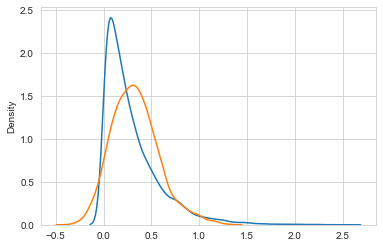

In [658]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(smcdiff_samples_0[:,0])

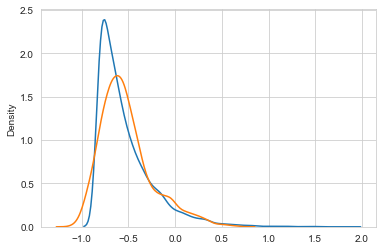

In [659]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(smcdiff_samples_neg[:,0])

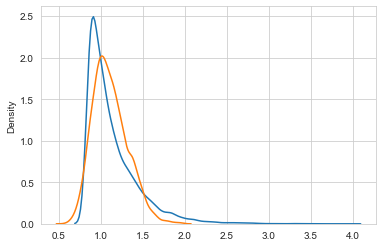

In [660]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(smcdiff_samples_pos[:,0])

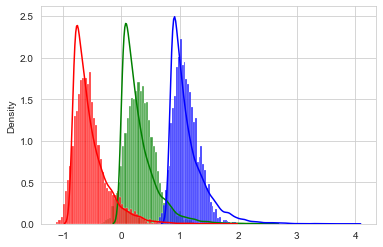

In [661]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(smcdiff_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(smcdiff_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(smcdiff_samples_neg[:,0], stat = 'density', color = 'red')

## Example 2

In [664]:
ckpt = torch.load('models/ex_2.pth', map_location=device)
score_model.load_state_dict(ckpt)
smcdiff_samples_0_2 = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 5000)

smcdiff_samples_pos_2 = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 5000)

smcdiff_samples_neg_2 = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 5000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

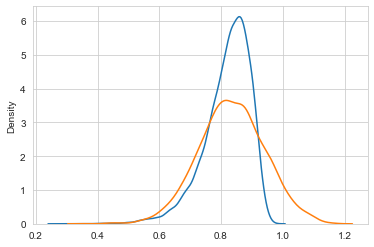

In [665]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(smcdiff_samples_pos_2[:,0])

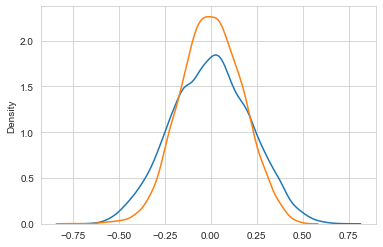

In [666]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(smcdiff_samples_0_2[:,0])

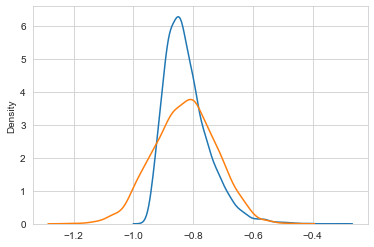

In [667]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(smcdiff_samples_neg_2[:,0])

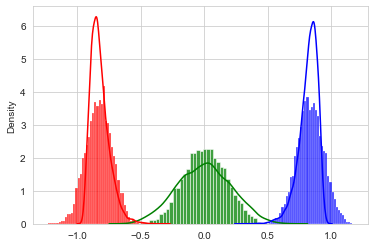

In [668]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(smcdiff_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(smcdiff_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(smcdiff_samples_neg_2[:,0], stat = 'density', color = 'red')

## Example 3

In [669]:
ckpt = torch.load('models/ex_3.pth', map_location=device)
score_model.load_state_dict(ckpt)
smcdiff_samples_pos_3 = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 5000)

smcdiff_samples_neg_3 = SMCDiff_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std_fn,
                           diffusion_coeff_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 5000)

<ipython-input-7-73aaf924e204>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
<ipython-input-7-73aaf924e204>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

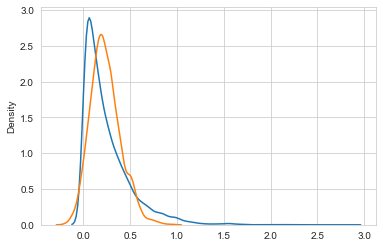

In [670]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(smcdiff_samples_pos_3[:,0])

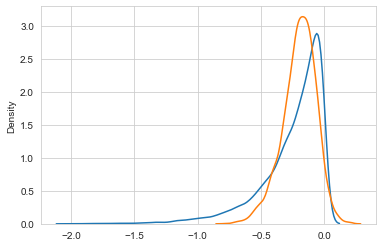

In [671]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(smcdiff_samples_neg_3[:,0])

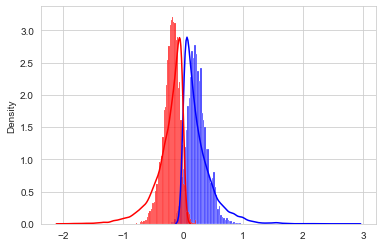

In [672]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(smcdiff_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(smcdiff_samples_neg_3[:,0], stat = 'density', color = 'red')

<hr style="border:2px solid black">

# Comparison

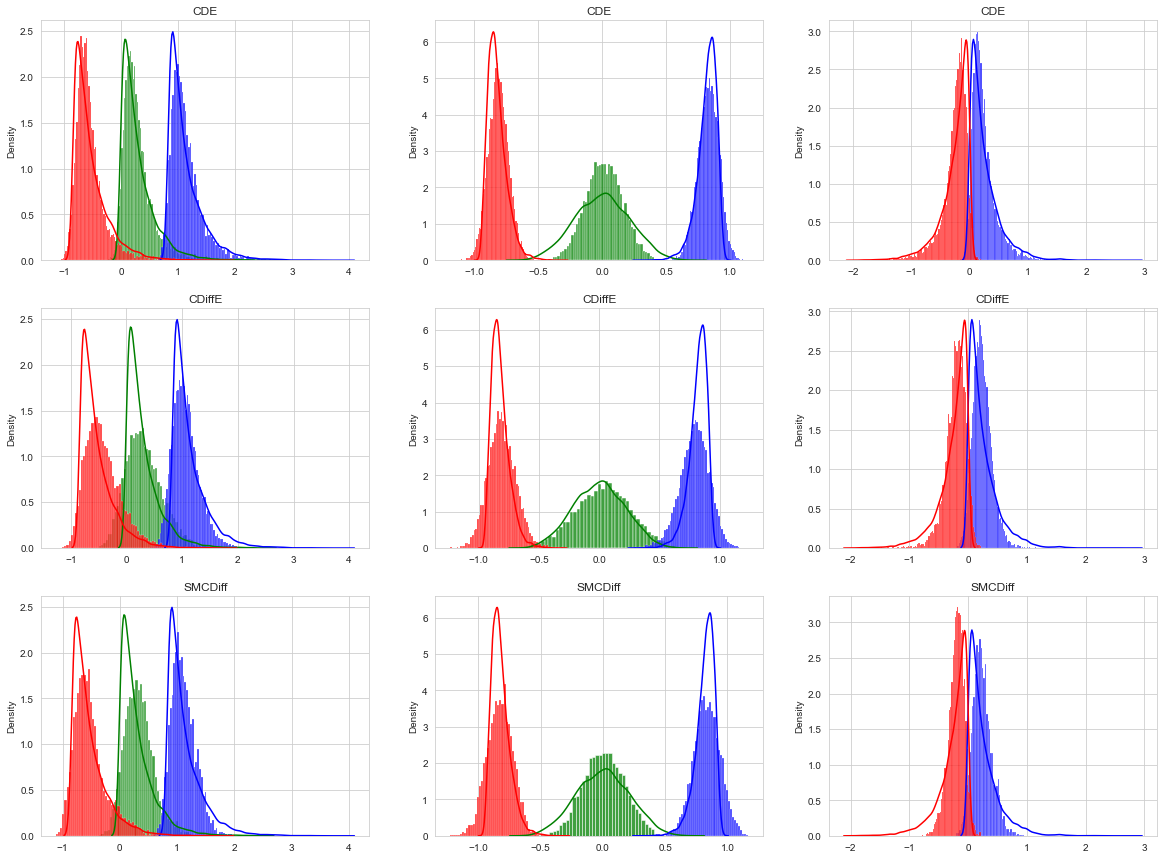

In [673]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))

def plot_row(s1,s2,s3,s4,s5,s6,s7,s8,row,title):
    sns.kdeplot(actual_samples_0, color = 'green', ax = axs[row,0])
    sns.histplot(s1[:,0], stat = 'density', color = 'green', ax = axs[row,0])
    sns.kdeplot(actual_samples_pos, color = 'blue', ax = axs[row,0])
    sns.histplot(s2[:,0], stat = 'density', color = 'blue', ax = axs[row,0])
    sns.kdeplot(actual_samples_neg, color = 'red', ax = axs[row,0])
    sns.histplot(s3[:,0], stat = 'density', color = 'red', ax = axs[row,0])

    sns.kdeplot(actual_samples_0_2, color = 'green', ax = axs[row,1])
    sns.histplot(s4[:,0], stat = 'density', color = 'green', ax = axs[row,1])
    sns.kdeplot(actual_samples_pos_2, color = 'blue', ax = axs[row,1])
    sns.histplot(s5[:,0], stat = 'density', color = 'blue', ax = axs[row,1])
    sns.kdeplot(actual_samples_neg_2, color = 'red', ax = axs[row,1])
    sns.histplot(s6[:,0], stat = 'density', color = 'red', ax = axs[row,1])

    sns.kdeplot(actual_samples_pos_3, color = 'blue', ax = axs[row,2])
    sns.histplot(s7[:,0], stat = 'density', color = 'blue', ax = axs[row,2])
    sns.kdeplot(actual_samples_neg_3, color = 'red', ax = axs[row,2])
    sns.histplot(s8[:,0], stat = 'density', color = 'red', ax = axs[row,2])

    axs[row,0].set_title(title)
    axs[row,1].set_title(title)
    axs[row,2].set_title(title)
    
plot_row(cde_samples_0, cde_samples_pos, cde_samples_neg, 
         cde_samples_0_2, cde_samples_pos_2, cde_samples_neg_2,
         cde_samples_pos_3, cde_samples_neg_3, 0, 'CDE')

plot_row(cdiffe_samples_0, cdiffe_samples_pos, cdiffe_samples_neg, 
         cdiffe_samples_0_2, cdiffe_samples_pos_2, cdiffe_samples_neg_2,
         cdiffe_samples_pos_3, cdiffe_samples_neg_3, 1, 'CDiffE')

plot_row(smcdiff_samples_0, smcdiff_samples_pos, smcdiff_samples_neg, 
         smcdiff_samples_0_2, smcdiff_samples_pos_2, smcdiff_samples_neg_2,
         smcdiff_samples_pos_3, smcdiff_samples_neg_3, 2, 'SMCDiff')